---
title: "Point-in-time joins with PySpark"
date: 2021-09-09
type: technical_note
draft: false
---

# Point-in-Time (PIT) joins in Hopsworks Feature Store

In order to create a training dataset, data scientists usually have to generate information about the future by putting themselves back in time, or travelling back in time.

Let's take the case of churn prediction: We want to predict which of our users will churn within the next few months. To train such a model we need to construct a training dataset containing rows for each of our users, one column indicating whether a user churned and X additional columns with features about the user, such as his historical purchases or interactions with the product.

Since we don't know the future yet (it's what we want to predict), to generate such prediction targets, we have to go back in time and determine which users churned in the last couple of months.

### Snapshot based time travel

If you have looked at our other time travel notebooks, the most simple solution to this problem would be to choose a single cutoff time for all our users. Using the time travel capabilities of the Feature Store with Apache Hudi make it easy enough to fetch data from a single point in time. This can work if features aren't frequently updated, however, when prediction target events of different users lie far apart and features are updated frequently you might leave a lot of information unused, hurting the accuracy of your model.

### Individual point-in-time correct cutoffs

A better approach includes using all information up to the time the prediction target event happened. So that means we still go back, let's say a maximum 6 months, in time, however, we want to remember the prediction target event time stamp on a user level (row level) and find the latest values of our prediction features before this point in time. The following diagrams illustrates this approach for one user:

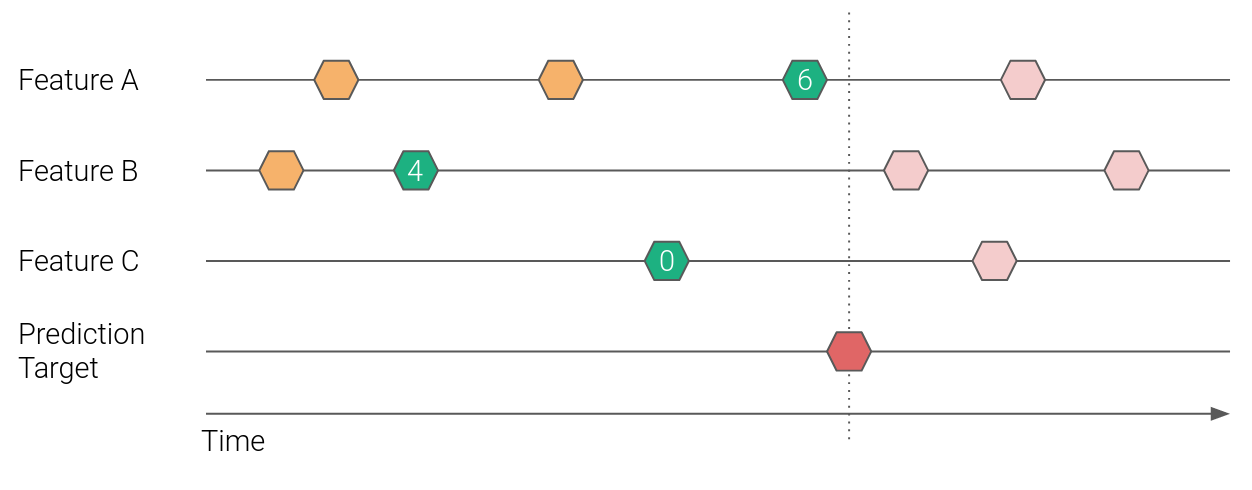

A problem often occurring at this stage is the possibility of leaking information from the future (light red signals) into the training dataset. This means using feature signals which happened after the prediction target event has to be strictly avoided. What we want to retrieve from the feature store are the green, and the green only, feature signals.

In this case it is not as simple as performing a time travel query with a single time stamp. This challenge is solved by a point-in-time correct join instead.
**Point-in-time joins** prevent feature leakage by recreating the state of the world at a single point in time for every entity or primary key value (user in our case).

**Hopsworks Feature Store** abstracts this complexity away by simply telling it where to find the relevant event time stamps for feature groups. We will go through the process in the rest of the notebook.

## Event-time enabled Feature Groups

For the Feature Store to be able to perform a PIT join, we need to tell it where to find the event time stamp within each feature group. Event-time is a timestamp indicating the instant in time when an event happened at the source of the event, so this is *not* an ingestion time stamp or the like, but instead should originate from your source systems.

To "event-time enable" a feature group, you set the `event_time` argument at feature group creation. We are using simple Integers to indicate the timestamps, for better readability.

### For simplicity we will create three feature groups
* `marketing` with customer id, complaints in the last 7 days, outbound activities in the last 7 days and coupons received in the last 14 days; 
* `contract` with customer id, contract_type;
* `churn` which will contain labels wether loan was cancelled `1` or rejected `0` with a timestamp when the contract was created or cancelled, note that this feature group has a composite primary key of customer id and a contract id, referring to the id in the contract feature group.

In [1]:
import hsfs
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import *

connection = hsfs.connection()
# get a reference to the feature store, you can access also shared feature stores by providing the feature store name
fs = connection.get_feature_store()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
15,application_1630405039893_0017,pyspark,idle,Link,Link


SparkSession available as 'spark'.
Connected. Call `.close()` to terminate connection gracefully.

In [2]:
marketing_schema = StructType([
  StructField("customer_id", IntegerType(), True),
  StructField("ts", LongType(), True),
  StructField("complaints_7d", IntegerType(), True),
  StructField("outbound_7d", IntegerType(), True),
  StructField("coupon_14d", IntegerType(), True)
])

contract_schema = StructType([
  StructField("contract_id", IntegerType(), True),
  StructField("ts", LongType(), True),
  StructField("contract_type", StringType(), True)
])

churn_schema =  StructType([
  StructField("customer_id", IntegerType(), True),
  StructField("contract_id", IntegerType(), True),
  StructField("ts", LongType(), True),
  StructField("contract_churn", IntegerType(), True)       
])

We will first load the Churn Feature Group with the initial contracts. We can assume there is a job running inserting new rows for every new contract into this feature group.

In [3]:
new_contracts = [
    Row(1, 100, 10010, 0),
    Row(2, 101, 10017, 0),
    Row(3, 102, 10035, 0),
    Row(4, 103, 10023, 0),
    Row(5, 104, 10546, 0),
    Row(6, 105, 10213, 0),
    Row(7, 106, 10056, 0),
    Row(8, 107, 10012, 0)
]

new_contracts_df = spark.createDataFrame(new_contracts, churn_schema)

At the same time some contracts will be cancelled and inserted into the feature group over time. We will perform this insertion with a bit of time difference, so that we can later demonstrate the capabilities of PIT joins together with time-travel queries.

In [4]:
churned_contracts = [
    Row(1, 100, 10356, 1),
    Row(5, 104, 10692, 1),
    Row(6, 105, 10375, 1),
    Row(8, 107, 10023, 1)
]

churned_contracts_df = spark.createDataFrame(churned_contracts, churn_schema)

Now let's create some mock data for the secondary feature groups, containing the actual explanatory features used to predict the churn.

The contract feature group is a feature group that gets new contracts appended with information about the contract itself only, such as the type of contract. Hence all timestamps are the same as the inital contract creation in the churn feature group.

In [5]:
contracts = [
    Row(100, 10010, "Long-term"),
    Row(101, 10017, "Short-term"),
    Row(102, 10035, "Trial"),
    Row(103, 10023, "Short-term"),
    Row(104, 10546, "Long-term"),
    Row(105, 10213, "Trial"),
    Row(106, 10056, "Long-term"),
    Row(107, 10012, "Short-term")
]

contracts_df = spark.createDataFrame(contracts, contract_schema)

The marketing activities feature group contains features related to outbound and inbound contacts to the customer. You can imagine these to be computed by a streaming application, updating the features every time new events arrive.

In the point in time join we want to get the latest of these updates just before or at the same time as the prediction event happened. Contracts can be in the training dataset twice, once when they haven't churned yet and then when they churned. The rows which should be picked for either of the target events are marked with a comment.

At the same time, always the latest state of the customer's marketing profile should be available in the online feature store.

In [6]:
marketing = [
    Row(1, 10010, 0, 0, 1), # this one
    Row(1, 10174, 3, 0, 4),
    Row(1, 10257, 7, 0, 3),
    Row(1, 10352, 3, 0, 5), # this one
    Row(1, 10753, 0, 0, 0),
    Row(1, 10826, 0, 0, 1), # online feature store
    
    Row(2, 10017, 0, 1, 1), # this one
    Row(2, 10021, 0, 1, 1),
    Row(2, 10034, 0, 1, 2), # online feature store
    
    Row(3, 10035, 1, 3, 0), # this one
    Row(3, 10275, 1, 2, 0),
    
    Row(5, 10546, 0, 1, 0), # this one
    Row(5, 10598, 2, 2, 1), # this one
    Row(5, 13567, 0, 1, 0),    
    Row(5, 16245, 0, 1, 0), # online feature store
    
    Row(6, 10213, 0, 0, 1), # this one
    Row(6, 10234, 0, 5, 0), # this one
    Row(6, 10436, 0, 0, 1), # online feature store
    
    Row(7, 10056, 0, 0, 0), # this one
    Row(7, 10056, 0, 1, 0),
    Row(7, 10056, 0, 2, 1),
    Row(7, 10056, 0, 3, 0), # online feature store
    
    Row(8, 10012, 0, 0, 1), # this one
    Row(8, 10023, 10, 0, 1), # this one
    Row(8, 10033, 0, 0, 1), # online feature store
]

marketing_df = spark.createDataFrame(marketing, marketing_schema)

### Create the feature groups

We are now ready to create our three feature groups. Note the additional argument we are passing, in order to tell the Feature Store which column should be used as `event_time`.

In [7]:
marketing_fg = fs.create_feature_group("marketing",
                                       version=1,
                                       description="Features about inbound/outbound communication with customers",
                                       online_enabled=True,
                                       statistics_config=False,
                                       primary_key=["customer_id"],
                                       event_time="ts")

In [8]:
marketing_fg.save(marketing_df)

In [9]:
contracts_fg = fs.create_feature_group("contracts",
                                       version=1,
                                       description="Contract information features",
                                       online_enabled=True,
                                       statistics_config=False,
                                       primary_key=["contract_id"],
                                       event_time="ts")

In [10]:
contracts_fg.save(contracts_df)

In [11]:
churn_fg = fs.create_feature_group("churn",
                                       version=1,
                                       description="Customer/contract information about activity of contract",
                                       online_enabled=True,
                                       statistics_config=False,
                                       primary_key=["customer_id", "contract_id"],
                                       event_time="ts")

In [12]:
churn_fg.save(new_contracts_df)

We insert the churned contracts, in a separate upsert step.

In [13]:
churn_fg.insert(churned_contracts_df)

### Constructing a Point-in-Time Join

The Feature Store HSFS API comes with a `Query` abstraction. Operations such as `.join` or `.select` on a feature group return such `Query` objects. Queries are solely based on metadata up until they are saved as training datasets or read into Dataframes.

There are **two requirements** to construct a point in time join:

1. All feature groups have to be event time enabled. If there is no event timestamp available, you can fall back on creating an ingestion timestamp in your feature engineering pipeline.
2. The label (feature) group is the Feature Group that contains the column that is defined as the "label" column when creating the training dataset. The **left-most feature group has to be the label group**, meaning this is the feature group of which the timestamps will be used as reference timestamp against which the explaining features are joined (dark red dots in the diagram above). In our case this is the churn feature group.

So let's construct the join:

In [14]:
query = churn_fg.select_all().join(contracts_fg.select(["contract_type"]), on=["contract_id"]) \
                             .join(marketing_fg.select(["complaints_7d", "outbound_7d", "coupon_14d"]), on=["customer_id"])

You can print and look at the constructed SQL join query. However, there is no need to go into this complexity, as it will all be handled by the feature store.

In [15]:
print(query.to_string())

WITH right_fg0 AS (SELECT *
FROM (SELECT `fg2`.`customer_id`, `fg2`.`contract_id`, `fg2`.`ts`, `fg2`.`contract_churn`, `fg0`.`contract_type`, RANK() OVER (PARTITION BY `fg2`.`contract_id`, `fg2`.`ts` ORDER BY `fg0`.`ts` DESC) pit_rank_hopsworks
FROM `fg2` `fg2`
INNER JOIN `fg0` `fg0` ON `fg2`.`contract_id` = `fg0`.`contract_id` AND `fg2`.`ts` >= `fg0`.`ts`) NA
WHERE `pit_rank_hopsworks` = 1), right_fg1 AS (SELECT *
FROM (SELECT `fg2`.`customer_id`, `fg2`.`contract_id`, `fg2`.`ts`, `fg2`.`contract_churn`, `fg1`.`complaints_7d`, `fg1`.`outbound_7d`, `fg1`.`coupon_14d`, RANK() OVER (PARTITION BY `fg2`.`customer_id`, `fg2`.`ts` ORDER BY `fg1`.`ts` DESC) pit_rank_hopsworks
FROM `fg2` `fg2`
INNER JOIN `fg1` `fg1` ON `fg2`.`customer_id` = `fg1`.`customer_id` AND `fg2`.`ts` >= `fg1`.`ts`) NA
WHERE `pit_rank_hopsworks` = 1) (SELECT `right_fg0`.`customer_id`, `right_fg0`.`contract_id`, `right_fg0`.`ts`, `right_fg0`.`contract_churn`, `right_fg0`.`contract_type`, `right_fg1`.`complaints_7d`, `righ

As explained above, the Query itself does not perform any join yet until you call an action such as `.read` on it:

In [16]:
query.read().show(20)

+-----------+-----------+-----+--------------+-------------+-------------+-----------+----------+
|customer_id|contract_id|   ts|contract_churn|contract_type|complaints_7d|outbound_7d|coupon_14d|
+-----------+-----------+-----+--------------+-------------+-------------+-----------+----------+
|          6|        105|10375|             1|        Trial|            0|          5|         0|
|          5|        104|10692|             1|    Long-term|            2|          2|         1|
|          5|        104|10546|             0|    Long-term|            0|          1|         0|
|          2|        101|10017|             0|   Short-term|            0|          1|         1|
|          7|        106|10056|             0|    Long-term|            0|          0|         0|
|          8|        107|10023|             1|   Short-term|           10|          0|         1|
|          1|        100|10356|             1|    Long-term|            3|          0|         5|
|          1|       

#### Filters on point-in-time queries

As with any other query, it is possible to apply filters to it.
For example, if you are planning to train only a model for a certain contract type:

In [17]:
churn_fg.select_all().join(
                        contracts_fg.select(["contract_type"])
                                    .filter(contracts_fg.contract_type == "Long-term")
                        , on=["contract_id"]) \
                     .join(marketing_fg.select(["complaints_7d", "outbound_7d", "coupon_14d"]), on=["customer_id"]).read().show(20)

+-----------+-----------+-----+--------------+-------------+-------------+-----------+----------+
|customer_id|contract_id|   ts|contract_churn|contract_type|complaints_7d|outbound_7d|coupon_14d|
+-----------+-----------+-----+--------------+-------------+-------------+-----------+----------+
|          5|        104|10692|             1|    Long-term|            2|          2|         1|
|          5|        104|10546|             0|    Long-term|            0|          1|         0|
|          7|        106|10056|             0|    Long-term|            0|          0|         0|
|          1|        100|10356|             1|    Long-term|            3|          0|         5|
|          1|        100|10010|             0|    Long-term|            0|          0|         1|
+-----------+-----------+-----+--------------+-------------+-------------+-----------+----------+

#### Combining time-travel and point-in-time join in one query

We performed a separate upsert on our churn feature group in order to be able to demonstrate time-travel, so let's look at the commit information:

In [18]:
commit_details = churn_fg.commit_details()
print(commit_details)

{1631088747000: {'committedOn': '20210908081227', 'rowsUpdated': 0, 'rowsInserted': 4, 'rowsDeleted': 0}, 1631088722000: {'committedOn': '20210908081202', 'rowsUpdated': 0, 'rowsInserted': 8, 'rowsDeleted': 0}}

As you can see, there are two commits: (1) the initial commit, which inserted the eight contracts. And (2) the upsert commit with the additinal four churned contracts.

Now we would like to query the state of the Feature Store at the time before the churned contracts were ingested:

In [19]:
# getting the correct timestamp, we sort by the commit time and get the string representation of the commit time
committed_on = commit_details[sorted(commit_details)[0]]["committedOn"]
committed_on

'20210908081202'

In [20]:
contracts_fg.commit_details()

{1631088686000: {'committedOn': '20210908081126', 'rowsUpdated': 0, 'rowsInserted': 8, 'rowsDeleted': 0}}

In [21]:
churn_fg.select_all().as_of(committed_on).read().show(20)

+-----------+-----------+-----+--------------+
|customer_id|contract_id|   ts|contract_churn|
+-----------+-----------+-----+--------------+
|          2|        101|10017|             0|
|          5|        104|10546|             0|
|          8|        107|10012|             0|
|          3|        102|10035|             0|
|          6|        105|10213|             0|
|          7|        106|10056|             0|
|          4|        103|10023|             0|
|          1|        100|10010|             0|
+-----------+-----------+-----+--------------+

And combining this with our point-in-time join:

In [22]:
query.as_of(committed_on).read().show(20)

+-----------+-----------+-----+--------------+-------------+-------------+-----------+----------+
|customer_id|contract_id|   ts|contract_churn|contract_type|complaints_7d|outbound_7d|coupon_14d|
+-----------+-----------+-----+--------------+-------------+-------------+-----------+----------+
|          5|        104|10546|             0|    Long-term|            0|          1|         0|
|          2|        101|10017|             0|   Short-term|            0|          1|         1|
|          7|        106|10056|             0|    Long-term|            0|          0|         0|
|          1|        100|10010|             0|    Long-term|            0|          0|         1|
|          6|        105|10213|             0|        Trial|            0|          0|         1|
|          8|        107|10012|             0|   Short-term|            0|          0|         1|
|          3|        102|10035|             0|        Trial|            1|          3|         0|
+-----------+-------

### Creating the training dataset

Creating the training dataset is now as simple as initializing the metadata with `.create_training_dataset()` and subsequently persisting it and materializing the query with `.save()`.

In [23]:
td = fs.create_training_dataset("churn_model",
                                version=1,
                                data_format="csv",
                                label=["contract_churn"])

In [24]:
td.save(query)

#### Querying the online feature store

We can reproduce the query and get the latest feature vector for each contract from the online feature store now.

**NOTE:**
- Any applied filter at the time of creating the training dataset is not applied during serving time. It is the responsibility of the application performing the lookup, to only provide contract ids which belong for example to a certain category. The reason for that is that we always want to get back a vector, applying a filter, might lead to no results.

In [25]:
td.get_serving_vector({"customer_id": 1, "contract_id": 100})

[1, 100, 10356, 'Long-term', 0, 0, 1]

In [26]:
td.get_serving_vector({"customer_id": 2, "contract_id": 101})

[2, 101, 10017, 'Short-term', 0, 1, 2]